In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
from dataclasses import dataclass
from transformers import Sam3Processor, Sam3Model
import torch
from PIL import Image
import requests
import cv2
from itertools import combinations
from sklearn.model_selection import train_test_split
import random
from scipy.ndimage import label
from typing import Union

/home/ubuntu/forge-images/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Imports for embedding models (loaded on-demand to save GPU memory)
from transformers import CLIPProcessor, CLIPModel, AutoImageProcessor, AutoModel, AutoProcessor
import open_clip

device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
model = Sam3Model.from_pretrained("facebook/sam3").to(device)
processor = Sam3Processor.from_pretrained("facebook/sam3")

Loading weights: 100%|██████████| 1468/1468 [00:02<00:00, 503.42it/s, Materializing param=vision_encoder.neck.fpn_layers.3.proj2.weight]                       


The OrderedVocab you are attempting to save contains holes for indices [1], your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains holes for indices [1], your vocabulary could be corrupted !


In [4]:
from dataclasses import dataclass

@dataclass
class Sam3Results:
    masks: np.ndarray
    boxes: np.ndarray
    scores: np.ndarray

@dataclass
class Sample:
    image: Image.Image
    samResults: Sam3Results

@dataclass
class MyImage:
    image: Image.Image
    file_name: str
    index: int
    size: int
    samResults: Union[Sam3Results, None] = None



In [160]:
def get_sam3_results(
    model: Sam3Model,
    processor: Sam3Processor,
    # List of PIL images
    my_images: list[MyImage],
    batch_size: int = 4,
) -> list[int]:

    new_samples = []
    i = 0

    while i < len(my_images):
        batch: list[MyImage] = []

        while i < len(my_images) and len(batch) < batch_size:
            batch.append(my_images[i])
            i += 1

        images = [my_image.image for my_image in batch]

        inputs = processor(images=images, text=["distinct object"] * len(images), return_tensors="pt").to(device)

        with torch.no_grad():
            outputs = model(**inputs)
            results_batch = processor.post_process_instance_segmentation(
                outputs,
                threshold=0.5,
                mask_threshold=0.4,
                target_sizes=inputs.get("original_sizes").tolist()
            )

        for my_image, results in zip(batch, results_batch):
            my_image.samResults = Sam3Results(
                    masks=results["masks"].detach().cpu().numpy(),
                    boxes=results["boxes"].detach().cpu().numpy(),
                    scores=results["scores"].detach().cpu().numpy()
                )

        # Clean up GPU memory after each batch
        del inputs, outputs, results_batch
        torch.cuda.empty_cache()

        if len(new_samples) % 100 == 0:
            print(f"Processed {len(new_samples)}/{len(images)} samples (batch size: {len(batch)}")

    return my_images



In [161]:

# get a list of images from a folder
def get_images_from_folder(folder_path: str) -> list[MyImage]:
    return [MyImage(Image.open(os.path.join(folder_path, f)), f, i, os.path.getsize(os.path.join(folder_path, f))) for i, f in enumerate(os.listdir(folder_path))]



authentic_images = get_images_from_folder("./train_images/authentic/")
len(authentic_images)

2377

In [162]:
authentic_images = [image for image in authentic_images if image.size < 2*10**6]
len(authentic_images)

2206

In [163]:
sam3_results = get_sam3_results(model, processor, authentic_images[0:10])

Processed 0/4 samples (batch size: 4
Processed 0/4 samples (batch size: 4
Processed 0/2 samples (batch size: 2


In [164]:
example = 8
sample_image = sam3_results[example]

In [165]:
candidate_masks = []
image_size = sample_image.size
for mask in sample_image.samResults.masks:
    mask_size = np.sum(mask)
    mask_area_ratio = mask_size / image_size
    if mask_area_ratio > 0.005 and mask_area_ratio < 0.2:
        candidate_masks.append(mask)
candidate_masks

[array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], shape=(107, 534)),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], shape=(107, 534)),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], shape=(107, 534))]

In [166]:
# Updated copy-paste function that accepts multiple offsets
def copy_paste_object(image, mask, offsets):
    """offsets can be a single (x, y) tuple or list of (x, y) tuples"""
    img = np.array(image)
    mask_bool = mask.astype(bool)

    # Find bounding box
    rows = np.any(mask_bool, axis=1)
    cols = np.any(mask_bool, axis=0)
    y_min, y_max = np.where(rows)[0][[0, -1]]
    x_min, x_max = np.where(cols)[0][[0, -1]]

    # Crop object
    object_crop = img[y_min:y_max+1, x_min:x_max+1]
    mask_crop = mask_bool[y_min:y_max+1, x_min:x_max+1]

    # Convert single offset to list
    if isinstance(offsets, tuple):
        offsets = [offsets]

    # Paste to all locations
    result = img.copy()
    new_mask = mask_bool.copy()  # Start with original mask

    for offset_x, offset_y in offsets:
        paste_y_end = offset_y + object_crop.shape[0]
        paste_x_end = offset_x + object_crop.shape[1]

        if paste_y_end <= result.shape[0] and paste_x_end <= result.shape[1]:
            result[offset_y:paste_y_end, offset_x:paste_x_end][mask_crop] = object_crop[mask_crop]
            new_mask[offset_y:paste_y_end, offset_x:paste_x_end] = mask_crop

    return Image.fromarray(result), new_mask

# Find non-overlapping offsets for multiple copies
def find_offsets(image, mask, num_copies):
    h, w = np.array(image).shape[:2]
    mask_bool = mask.astype(bool)

    # Get object size
    rows = np.any(mask_bool, axis=1)
    cols = np.any(mask_bool, axis=0)
    obj_h = np.sum(rows)
    obj_w = np.sum(cols)

    # Track occupied areas (original + copies)
    occupied = mask_bool.copy()
    offsets = []

    for _ in range(num_copies):
        for _ in range(1000):  # Try up to 1000 times
            offset_x = random.randint(0, max(1, w - obj_w))
            offset_y = random.randint(0, max(1, h - obj_h))

            # Check overlap
            if not np.any(occupied[offset_y:offset_y+obj_h, offset_x:offset_x+obj_w]):
                offsets.append((offset_x, offset_y))
                occupied[offset_y:offset_y+obj_h, offset_x:offset_x+obj_w] = True
                break

    return offsets

# # Use first mask and paste at random location
test_mask = candidate_masks[0]

In [190]:
# Copy-paste multiple objects with overlap prevention toggle (FIXED)
def copy_paste_objects(image, masks, num_copies_list, prevent_overlap=True):
    """masks: list of masks, num_copies_list: list of copy counts per object
    prevent_overlap: if True, objects won't overlap with each other
    Returns: (forged_image, list_of_masks) - one mask per object"""
    img = np.array(image)
    h, w = img.shape[:2]
    occupied = np.zeros((h, w), dtype=bool)
    result = img.copy()
    object_masks = []

    # Mark all original masks as occupied first
    if prevent_overlap:
        for mask in masks:
            occupied[mask.astype(bool)] = True

    for mask, num_copies in zip(masks, num_copies_list):
        mask_bool = mask.astype(bool)
        rows = np.any(mask_bool, axis=1)
        cols = np.any(mask_bool, axis=0)
        y_min, y_max = np.where(rows)[0][[0, -1]]
        x_min, x_max = np.where(cols)[0][[0, -1]]
        obj_h, obj_w = y_max - y_min + 1, x_max - x_min + 1

        object_crop = img[y_min:y_max+1, x_min:x_max+1]
        mask_crop = mask_bool[y_min:y_max+1, x_min:x_max+1]
        obj_mask = mask_bool.copy()

        for _ in range(num_copies):
            for _ in range(1000):
                offset_x = random.randint(0, max(1, w - obj_w))
                offset_y = random.randint(0, max(1, h - obj_h))

                paste_region = occupied[offset_y:offset_y+obj_h, offset_x:offset_x+obj_w]
                if not prevent_overlap or not np.any(paste_region[mask_crop]):
                    result[offset_y:offset_y+obj_h, offset_x:offset_x+obj_w][mask_crop] = object_crop[mask_crop]
                    obj_mask[offset_y:offset_y+obj_h, offset_x:offset_x+obj_w] = mask_crop
                    if prevent_overlap:
                        occupied[offset_y:offset_y+obj_h, offset_x:offset_x+obj_w][mask_crop] = True
                    break

        object_masks.append(obj_mask)

    return Image.fromarray(result), object_masks

In [191]:
# # Copy-paste multiple objects with overlap prevention toggle
# def copy_paste_objects(image, masks, num_copies_list, prevent_overlap=True):
#     """masks: list of masks, num_copies_list: list of copy counts per object
#     prevent_overlap: if True, objects won't overlap with each other
#     Returns: (forged_image, list_of_masks) - one mask per object"""
#     img = np.array(image)
#     h, w = img.shape[:2]
#     occupied = np.zeros((h, w), dtype=bool)
#     result = img.copy()
#     object_masks = []

#     for mask, num_copies in zip(masks, num_copies_list):
#         mask_bool = mask.astype(bool)
#         rows = np.any(mask_bool, axis=1)
#         cols = np.any(mask_bool, axis=0)
#         y_min, y_max = np.where(rows)[0][[0, -1]]
#         x_min, x_max = np.where(cols)[0][[0, -1]]
#         obj_h, obj_w = y_max - y_min + 1, x_max - x_min + 1

#         object_crop = img[y_min:y_max+1, x_min:x_max+1]
#         mask_crop = mask_bool[y_min:y_max+1, x_min:x_max+1]
#         obj_mask = mask_bool.copy()

#         if prevent_overlap:
#             occupied[mask_bool] = True

#         for _ in range(num_copies):
#             for _ in range(1000):
#                 offset_x = random.randint(0, max(1, w - obj_w))
#                 offset_y = random.randint(0, max(1, h - obj_h))

#                 paste_region = occupied[offset_y:offset_y+obj_h, offset_x:offset_x+obj_w]
#                 if not prevent_overlap or not np.any(paste_region[mask_crop]):
#                     result[offset_y:offset_y+obj_h, offset_x:offset_x+obj_w][mask_crop] = object_crop[mask_crop]
#                     obj_mask[offset_y:offset_y+obj_h, offset_x:offset_x+obj_w] = mask_crop
#                     if prevent_overlap:
#                         occupied[offset_y:offset_y+obj_h, offset_x:offset_x+obj_w][mask_crop] = True
#                     break

#         object_masks.append(obj_mask)

#     return Image.fromarray(result), object_masks

In [175]:
offsets = find_offsets(sample_image.image, test_mask, 5)
new_image, new_mask = copy_paste_object(sample_image.image, test_mask, offsets)
new_image.save("./ourtraining/duplicate_1.png")


In [176]:
# # Copy-paste multiple objects with non-overlapping copies
# def copy_paste_objects(image, masks, num_copies_list):
#     """masks: list of masks, num_copies_list: list of copy counts per object
#     Returns: (forged_image, list_of_masks) - one mask per object"""
#     img = np.array(image)
#     h, w = img.shape[:2]
#     occupied = np.zeros((h, w), dtype=bool)
#     result = img.copy()
#     object_masks = []

#     for mask, num_copies in zip(masks, num_copies_list):
#         mask_bool = mask.astype(bool)
#         rows = np.any(mask_bool, axis=1)
#         cols = np.any(mask_bool, axis=0)
#         y_min, y_max = np.where(rows)[0][[0, -1]]
#         x_min, x_max = np.where(cols)[0][[0, -1]]
#         obj_h, obj_w = y_max - y_min + 1, x_max - x_min + 1

#         object_crop = img[y_min:y_max+1, x_min:x_max+1]
#         mask_crop = mask_bool[y_min:y_max+1, x_min:x_max+1]
#         obj_mask = mask_bool.copy()
#         occupied[y_min:y_max+1, x_min:x_max+1] = True

#         for _ in range(num_copies):
#             for _ in range(1000):
#                 offset_x = random.randint(0, max(1, w - obj_w))
#                 offset_y = random.randint(0, max(1, h - obj_h))
#                 if not np.any(occupied[offset_y:offset_y+obj_h, offset_x:offset_x+obj_w]):
#                     result[offset_y:offset_y+obj_h, offset_x:offset_x+obj_w][mask_crop] = object_crop[mask_crop]
#                     obj_mask[offset_y:offset_y+obj_h, offset_x:offset_x+obj_w] = mask_crop
#                     occupied[offset_y:offset_y+obj_h, offset_x:offset_x+obj_w] = True
#                     break

#         object_masks.append(obj_mask)

#     return Image.fromarray(result), object_masks

In [192]:
len(candidate_masks)

3

In [221]:
new_image, new_mask = copy_paste_objects(sample_image.image, candidate_masks[:2], [2,1])
new_image.save("./ourtraining/duplicate_2.png")

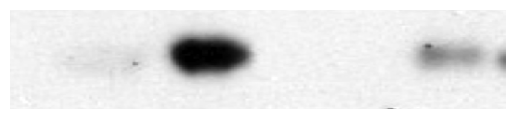

In [222]:
plt.imshow(sample_image.image)
# no axis
plt.axis("off")
plt.show()

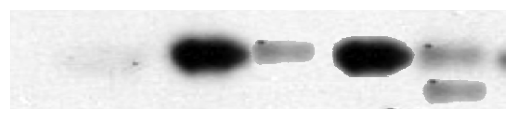

In [223]:
plt.axis("off")
plt.imshow(new_image)

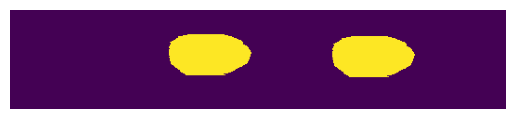

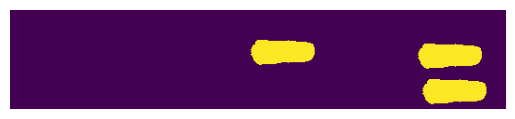

In [224]:
plt.axis("off")
plt.imshow(new_mask[1])
plt.axis("off")
plt.show()
plt.imshow(new_mask[0])
plt.axis("off")
plt.show()
